In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)


from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

# Load data
data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')
data, labels, windows = util.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wdata = util.sliding_window_1D(data, wlen=48)

# A Time-Dependent Estimator

## Spotting the Problem

**The sequence-based estimator we built learns from all the training data**

This means it will learn from both these series, for example:

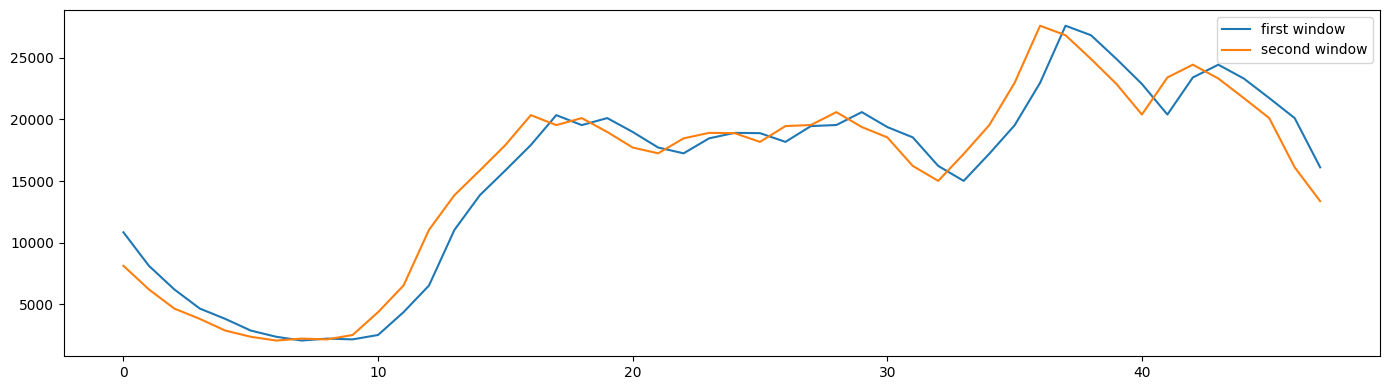

In [2]:
plt.figure(figsize=figsize)
plt.plot(wdata.iloc[0], label='first window')
plt.plot(wdata.iloc[1], label='second window')
plt.legend()
plt.tight_layout()

## Spotting the Problem

**Let us consider the first two window applications**

* In the first window, the observations are $x_0, x_1$ and so on
* In the second window, the observations are $x_1, x_2$ and so on

$x_0$ is number of taxis as 00:00, $x_1$ at 00:30, and so on

* Hence, the first observation in the first window corresponds to 00:00
* ...But in the second window corresponds to 00:30

**Our estimator learns a distribution for the _observations_:**

* Moving the window forward changes "who is who"
* We learn the distribution of $x_0$ (and its correlations) _multiple times_!

The learning problem is still well defined, but also _very complex_

**This is the reason for (most of) the noise in the alarm signal**

## Rewind a Little

**Remember _why_ we introduced the sequence based estimator?**

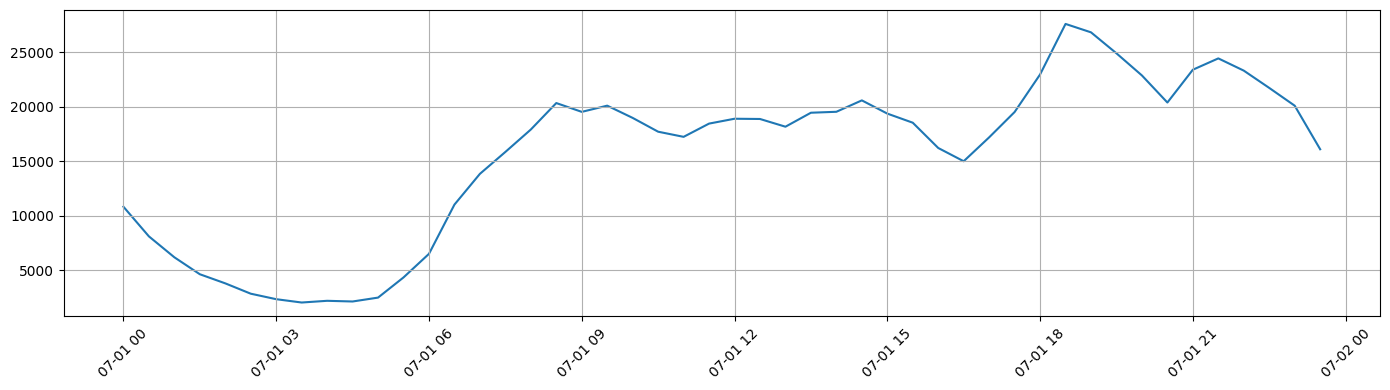

In [3]:
util.plot_series(data.iloc[:48], figsize=figsize)

* We wanted to take advantage of correlation between nearby points

## ...Then Forward Again

**But there is more! Let's look just a little bit further**

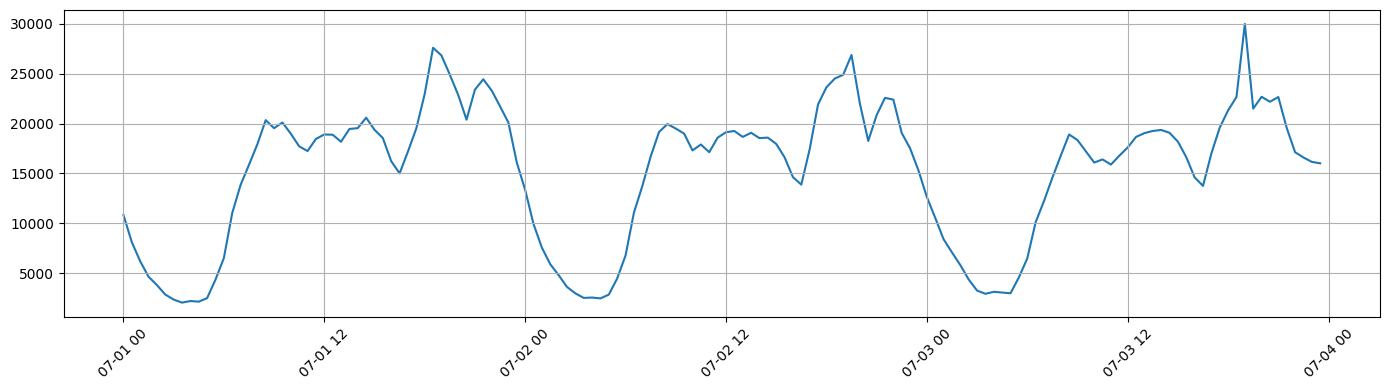

In [4]:
util.plot_series(data.iloc[:3*48], figsize=figsize)

* There is recurring pattern!
* I.e. the series is _approximately periodic_

## Determine the Period

**This is even clearer in the autocorrelation plot**

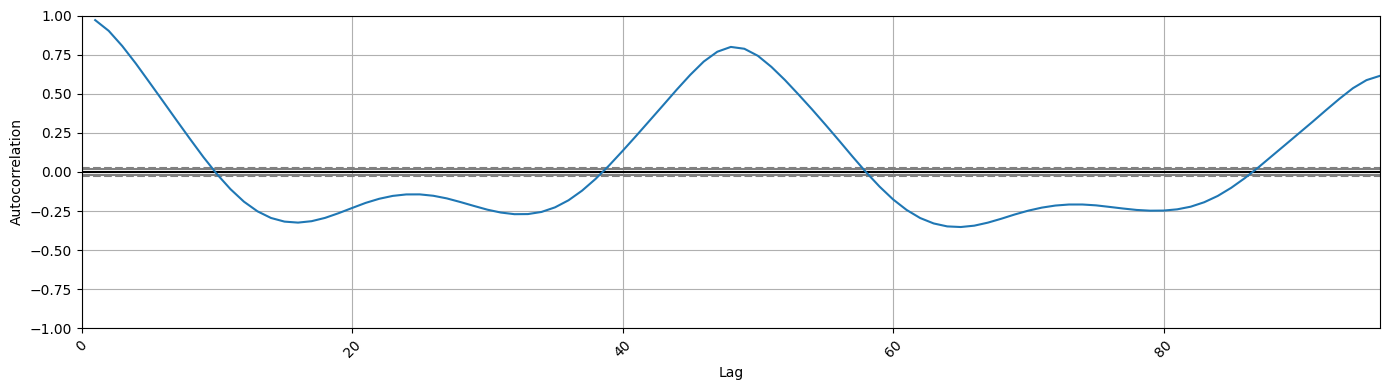

In [5]:
util.plot_autocorrelation(data, max_lag=96, figsize=figsize)

* There is _strong peak at 48_ time steps (a time step is 30 minutes)
* This is consistent with a period of 24 hours

## Reevaluate

**Let's recap our situation**

Our sequence-based estimator

* ...Is solving a uselessly complicated problem
* ...And it's not using all the available knowledge

> **These are both _very serious drawbacks_**

In any problem:

* _Never_ introduce complications unless they are worth it
* _Never_ willingly throw away information

<div class=big>Can we do something to tackle both problems?</div>

## Time as an Additional Input

**One way to look at that**

...Is that the distribution _depends on the time of the day_

* Therefore, we should consider the number of taxi calls $x$
* ...And the time of the day $t$ together

**Let us extract (from the index) the time information information:**

In [6]:
dayhour = (data.index.hour + data.index.minute / 60)

We can then add it as a separate column to the data:

In [7]:
data2 = data.copy()
data2['dayhour'] = dayhour

## Multivariate Distribution

**Let us examine the resulting multivariate distribution**

We can use a 2D histogram:

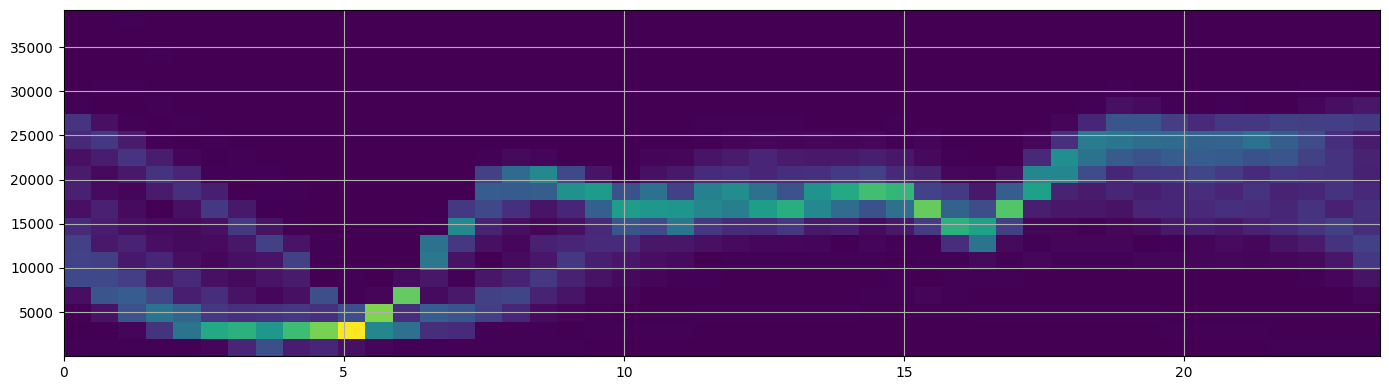

In [8]:
util.plot_histogram2d(data2['dayhour'], data2['value'], bins=(48, 20), figsize=figsize)

* x = time, y = value, color = frequency of occurrence

## Anomaly Detection with Controlled Variables

**If we feed this information to KDE**

...We learn an estimator for the _joint_ PDF:

$$
f(t, x)
$$

...Which is not exactly what we were looking for

**Assume we flag an anomaly when $f(t, x) \leq \theta$**

* This may happen when $x$ (the number of cars) takes an unlikely value
* ...Or when $t$ (the time) does

**Except that the _time is completely predictable_**

* Any different in its estimated density is only due to sampling choices
* In practice, it's a _controlled variable_

## Anomaly Detection with Controlled Variables

**What we really care about is the _conditional density_, i.e.**

$$
f(x \mid t)
$$

* I.e. the density value of the observed value of $x$
* Assuming that the time $t$ is _known_

**Our true anomaly detection conditions should then be:**

$$
f(x \mid t) \leq \varepsilon
$$

...We know how to approximate only to the _joint_ density function $f(t, x)$

> **How to handle the conditioning variable?**

## Anomaly Detection with Controlled Variables

**There's more than one way to do it**

...The one we'll see starts with the definition of conditional probability:

$$
f(t, x) = f(x \mid t) f(t)
$$

Meaning that we can detect anomalies by evaluating:

$$
\frac{f(t, x)}{f(t)} \leq \varepsilon
$$

**In order to pull this off, we need**

* An estimator for $f(t, x)$, which we already have
* An estimator for $f(t)$, which we can easily obtain (e.g. using KDE again)

**...But in our specific case, things are _even simpler_**

## Time Distribution

**In particular, the distribution of time values is uniform:**

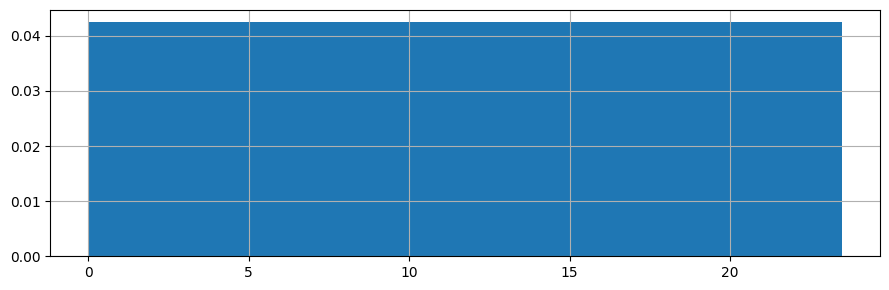

In [9]:
util.plot_histogram(data2['dayhour'], bins=48)

## Our Time-Dependent Estimator

**In non-degenerate cases, our condition can always be rewritten:**

$$
\frac{f(t, x)}{f(t)} \leq \varepsilon \quad \longrightarrow \quad f(t, x) \leq \varepsilon f(t)
$$

* But since $f(t)$ is constant this is equivalent to checking the joint probability
* ...With a modified threshold

$$
f(t, x) \leq \varepsilon^\prime
$$

* The threshold $\varepsilon^\prime$ now represents $\varepsilon f(t)$
* ...But since we still need to choose it value, it make little difference to us

**Hence, for this problem we can use $f(t, x)$ for anomaly detection**

## Choosing a Bandwidth

**We now need to pick a threshold**

* We can use grid search and cross-validation again
* ...But this time we need to make sure to _normalize the data_

In [10]:
scaler = MinMaxScaler()
data2_n_tr = data2[data2.index < train_end].copy()
data2_n_tr[:] = scaler.fit_transform(data2_n_tr)
data2_n = data2.copy()
data2_n[:] = scaler.transform(data2)

**This is due to a low-level technical detail:**

* scikit-learn uses a very efficient KDE implementation
* ...But it requires using _the same bandwidth_ for all input dimensions

Normalization makes this drawback less impactful

## Choosing a Bandwidth

**We can then optimize the bandwidth as usual**

We'll use cross-validation, since we have vector input

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'bandwidth': np.linspace(0.001, 0.01, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
opt.fit(data2_n_tr);
opt.best_params_

{'bandwidth': np.float64(0.006)}

* As another small advantage of normalization
* ...Choosing the grid search range becomes a bit easier

## Alarm Signal

**Let us obtain the alarm signal**

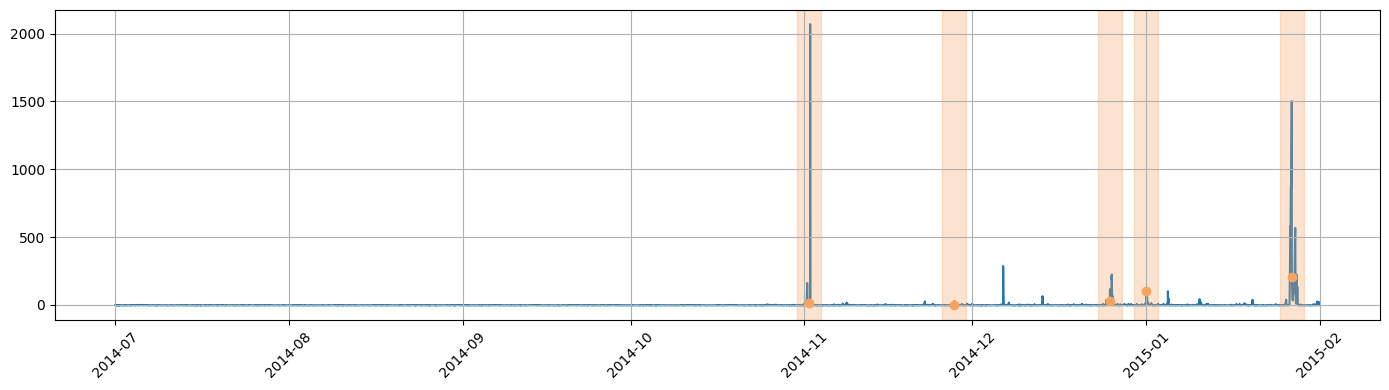

In [12]:
ldens2 = opt.score_samples(data2_n)
signal2 = pd.Series(index=data2.index, data=-ldens2)
util.plot_series(signal2, labels=labels, windows=windows, figsize=figsize)

## Threshold Optimization

**Now, let us optimize our threshold:**

In [13]:
signal2_opt = signal2[signal2.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr2_range = np.linspace(10, 100, 100)
best_thr2, best_cost2 = util.opt_thr(signal2_opt, labels_opt, windows_opt, cmodel, thr2_range)
print(f'Best threshold: {best_thr2:.3f}, corresponding cost: {best_cost2:.3f}')

Best threshold: 27.273, corresponding cost: 9.000


On the whole dataset:

In [14]:
c2tst = cmodel.cost(signal2, labels, windows, best_thr2)
print(f'Cost on the whole dataset {c2tst}')

Cost on the whole dataset 18


* It was 45 for the first approach and 30 for the second

<div class=big>There is a second period in the data!<br>Can you guess which one?</div>